# 1.  Preprocessing

In [177]:
# import libraries
import glob

import matplotlib.pyplot as plt
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import pandas as pd
import re

import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [178]:
# read data from files and convert a pandas data frame
def make_data(file_path, column_names):
    
    df = pd.DataFrame(columns = column_names)
    for file in glob.glob(file_path):
        # get name from file
        name = str(file).replace(".txt","")
        name = str(name).replace("data/public_figures/","")
        
        # get text from bio
        with open(file) as f:
            bio = f.read()
            f.close()
    
        df = df.append({"name" :name, "bio":bio}, 
                    ignore_index = True)
    
    return df
            
file_path = "data/public_figures/*.txt"
data = make_data(file_path,  ["name", "bio"])    

In [179]:
# view data
data.head(10)

,name,bio
0,Pol_Pot,Pol Pot[a] (born Saloth Sâr;[b] 19 May 1925 – ...
1,Jennifer_Lopez,"Jennifer Lynn Lopez[2] (born July 24, 1969), a..."
2,John_Locke,John Locke FRS (/lɒk/; 29 August 1632 – 28 Oct...
3,Robert_Mugabe,Robert Gabriel Mugabe (/mʊˈɡɑːbi/;[1] Shona: [...
4,Beatles,The Beatles were an English rock band formed i...
5,MTG,"Marjorie Taylor Greene (born May 27, 1974), al..."
6,Nikolai_Gogol,"Nikolai Vasilyevich Gogol (/ˈɡoʊɡəl, ˈɡoʊɡɔːl/..."
7,John_Calvin,John Calvin (/ˈkælvɪn/;[1] Middle French: Jehu...
8,Osama_binLaden,Osama bin Mohammed bin Awad bin Laden[1][7] /o...
9,Huldrych_Zwingli,Huldrych Zwingli[a] or Ulrich Zwingli[b] (1 Ja...


In [180]:
# define function to pre-process text
def preprocess_text(text):
    
    # tokenize text by sentence and then words
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # remove OCR noises
    tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # do stemming
    stemmer = SnowballStemmer("english")
    text = [stemmer.stem(token) for token in tokens]
    
    return text

# 2. Feature Engineering

In [181]:
# Create TF-IDF Vectorizer
def create_tfidf_matrix(data, column_name):
    
    # create a tfidf vectorizer
    # max_df = 0.5 - ignore words that occcur in more than 50% of docs
    # min_df = 0.01 - ignore words that occur in less than 1% of docs
    # ngram_range: inclues unigram, bigram, trigram
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.5, 
                                       max_features=1000,
                                       min_df=0.01, 
                                       stop_words='english',
                                       use_idf=True, 
                                       tokenizer=preprocess_text,
                                       ngram_range=(1,3))
    
    tfidf_matrix = tfidf_vectorizer.fit_transform([text for text in data[column_name]])
    
    return tfidf_matrix

tfidf_matrix = create_tfidf_matrix(data, "bio")    

# 3. GMM Clustering

In [182]:
def fit_gmm(matrix, n):
    # create n number clusters using GMM and get cluster labels
    gmm = GaussianMixture(n_components=n)
    gmm.fit(matrix.toarray())
    labels = gmm.predict(matrix.toarray())
    
    return labels

clusters = fit_gmm(tfidf_matrix, 5).tolist()

# assign cluster labels to the origina data
data["cluster"] = clusters

# Get counts of people in each cluster
data['cluster'].value_counts() 

2    39
0    18
3    16
4    15
1    12
Name: cluster, dtype: int64

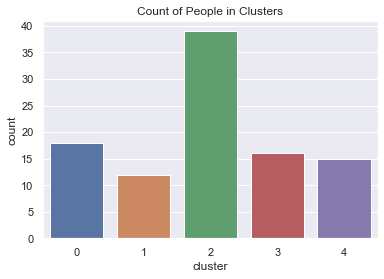

In [183]:
#  Visualize
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="cluster", data=data).set_title("Count of People in Clusters")
plt.show()

In [194]:
# reviewing people in cluster 2
data[data.cluster == 2].head(15)

,name,bio,cluster
5,MTG,"Marjorie Taylor Greene (born May 27, 1974), al...",2
10,Pat_Robertson,"Marion Gordon ""Pat"" Robertson (born March 22, ...",2
11,James_Madison,"James Madison Jr. (March 16, 1751[b] – June 28...",2
12,George_Washington,"George Washington (February 22, 1732[b] – Dece...",2
13,Donald_Trump,"Donald John Trump (born June 14, 1946) is an A...",2
15,AOC,Alexandria Ocasio-Cortez (/oʊˌkɑːsioʊ kɔːrˈtɛz...,2
16,Richard_Nixon,"Richard Milhous Nixon (January 9, 1913 – April...",2
17,George_Bush,"George Walker Bush (born July 6, 1946) is an A...",2
18,John_Hancock,"John Hancock (January 23, 1737 [O.S. January 1...",2
23,Barack_Obama,Barack Hussein Obama II (/bəˈrɑːk huːˈseɪn oʊˈ...,2


In [195]:
# reviewing people in cluster 0
data[data.cluster == 0].head(15)

,name,bio,cluster
2,John_Locke,John Locke FRS (/lɒk/; 29 August 1632 – 28 Oct...,0
6,Nikolai_Gogol,"Nikolai Vasilyevich Gogol (/ˈɡoʊɡəl, ˈɡoʊɡɔːl/...",0
19,Joyce_Meyer,Joyce Meyer is one of the world's leading Bibl...,0
26,Wrights_Brothers,"The Wright brothers – Orville (August 19, 1871...",0
34,Marie_Curie,Marie Salomea Skłodowska Curie (/ˈkjʊəri/ KEWR...,0
39,Voltaire,François-Marie Arouet (French: [fʁɑ̃swa maʁi a...,0
42,Fyodor_Dostoevsky,Fyodor Mikhailovich Dostoevsky[a] (/ˌdɒstəˈjɛf...,0
44,Nicolas_Tesla,Nikola Tesla (/ˈtɛslə/ TESS-lə; Serbian Cyrill...,0
51,JJ_Rosseau,"Jean-Jacques Rousseau (UK: /ˈruːsoʊ/, US: /ruː...",0
56,Alex_Pushkin,Alexander Sergeyevich Pushkin (English: /ˈpʊʃk...,0


In [196]:
# reviewing people in cluster 1
data[data.cluster == 1].head(15)

,name,bio,cluster
1,Jennifer_Lopez,"Jennifer Lynn Lopez[2] (born July 24, 1969), a...",1
4,Beatles,The Beatles were an English rock band formed i...,1
22,Adele,Adele Laurie Blue Adkins MBE (/əˈdɛl/; born 5 ...,1
24,Bee_Gees,The Bee Gees were a music group formed in 1958...,1
25,Justin_Timberlake,"Justin Randall Timberlake (born January 31, 19...",1
29,Aerosmith,Aerosmith is an American rock band formed in B...,1
30,Nirvana,Nirvana was an American rock band formed in Ab...,1
36,Justin_Bieber,"Justin Drew Bieber (/biːbər/; born March 1, 19...",1
63,Taylor_Swift,"Taylor Alison Swift (born December 13, 1989) i...",1
75,Britney_Spears,"Britney Jean Spears (born December 2, 1981) is...",1


In [197]:
# reviewing people in cluster 3
data[data.cluster == 3].head(15)

,name,bio,cluster
7,John_Calvin,John Calvin (/ˈkælvɪn/;[1] Middle French: Jehu...,3
9,Huldrych_Zwingli,Huldrych Zwingli[a] or Ulrich Zwingli[b] (1 Ja...,3
21,Gottfried_Leibniz,Gottfried Wilhelm (von) Leibniz[a][b] (/ˈlaɪbn...,3
28,Immanuel_Kant,"Immanuel Kant (UK: /kænt/,[20][21] US: /kɑːnt/...",3
31,John_Piper,"John Stephen Piper (born January 11, 1946) is ...",3
35,Mother_Teresa,Mother Mary Teresa Bojaxhiu[6] (born Anjezë Go...,3
45,Pope_John_Paul_II,Pope John Paul II (Latin: Ioannes Paulus II; I...,3
54,Francis_Bacon,"Francis Bacon, 1st Viscount St Alban,[a] Kt PC...",3
57,Louis_Pasteur,"Louis Pasteur ForMemRS (/ˈluːi pæˈstɜːr/, Fren...",3
65,Pope_Leo_X,Pope Leo X (born Giovanni di Lorenzo de' Medic...,3


In [198]:
# reviewing people in cluster 4
data[data.cluster == 4].head(15)

,name,bio,cluster
0,Pol_Pot,Pol Pot[a] (born Saloth Sâr;[b] 19 May 1925 – ...,4
3,Robert_Mugabe,Robert Gabriel Mugabe (/mʊˈɡɑːbi/;[1] Shona: [...,4
8,Osama_binLaden,Osama bin Mohammed bin Awad bin Laden[1][7] /o...,4
14,Adolf_Hitler,Adolf Hitler (German: [ˈadɔlf ˈhɪtlɐ] (About t...,4
20,Joseph_Stalin,"Joseph Vissarionovich Stalin,[f] (18 December ...",4
32,Oral_Roberts,"Granville Oral Roberts (January 24, 1918 – Dec...",4
53,Idi_Amin,"Idi Amin Dada Oumee (/ˈiːdi ɑːˈmiːn, ˈɪdi -/, ...",4
55,Tony_Blair,Anthony Charles Lynton Blair (born 6 May 1953)...,4
59,Saddam_Hussein,Saddam Hussein Abd al-Majid al-Tikriti (/hʊˈse...,4
66,Hugo_Grotius,Hugo Grotius (/ˈɡroʊʃiəs/; 10 April 1583 – 28 ...,4


# 4. Similarity Calculation

In [184]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_dist = 1 - cosine_similarity(tfidf_matrix)

# 5. Hierarchical Clustering

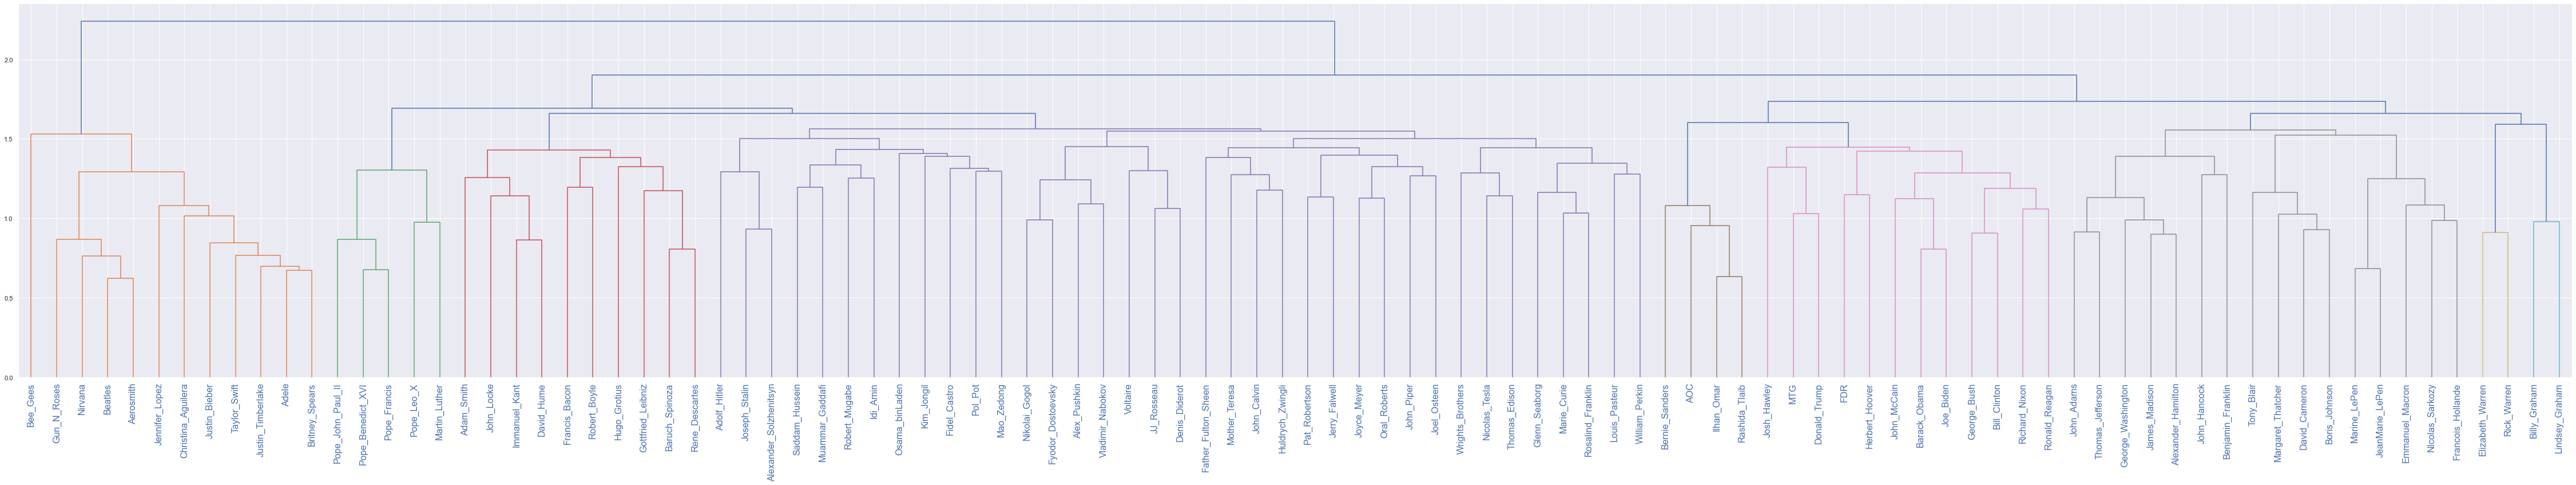

In [186]:
%matplotlib inline

# create linkage or merging betweenc clusters
den_matrix = linkage(similarity_dist, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(den_matrix,
               labels=[name for name in data["name"]],
               leaf_rotation=90,
               leaf_font_size=16,
)

# plot dendrogram
figure = plt.gcf()
_ = [lbl.set_color('b') for lbl in plt.gca().get_xmajorticklabels()]
figure.set_size_inches(80, 12)
plt.show()

# save figure
figure.savefig("bio_dendrogram.png")